# Weekly Sales Forecasting

The purpose of this project is to forecast weekly sales for each department in 45 stores & also to carry out statistical analysis to help improve financial planning of the national retail store. A forecast is based on historical sales data and is done for a particular period of a time in the near future, usually the next calendar year. A sales forecast enables a company to make informed business decisions regarding inventory or cash flow or plan for growth.

Data transformation and machine learning will be used to create a model that will predict weekly_sales when given information on store, department, date & IsHoliday.

The data for this model is relatively simplified as it has very few missing areas. The raw data consists of a training dataset with the features listed above and their corresponding weekly_sales. Twenty percent of this training dataset was split into a test dataset with corresponding weekly_sales so accuracy and error of the model could be determined.

The features in this data set are described as below:

- Store: The store number
- Dept: The department number
- Date: date of sale
- IsHoliday: Whether the week is a special holdiay week

In [1]:
#import required libraries
import pandas as pd
import sklearn as sk
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
import warnings
warnings.filterwarnings('ignore')

from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from statsmodels.tsa.arima_model import ARIMA, ARMAResults
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib


# Data Preparation
Define relevant functions needed in the span of the project

In [2]:
#function to load the data into a Pandas Dataframe
def load_f(file):
    return pd.read_csv(file)

#scatter plots 
def scatter_data(df, col):
    plt.figure(figsize = (12,8))
    plt.scatter(df[col], df['Weekly_Sales'] )
    plt.ylabel('Weekly_Sales')
    plt.xlabel(col)

#regression plots
def reg_data(df, col):
    plt.figure(figsize=(12,8))
    sns.regplot(x=df[col], y = df['Weekly_Sales'], data = df, line_kws = {'color' : 'red'})    
    plt.ylim(0,)
    
#residual plots 
def res_data(df,col):
    plt.figure(figsize=(12,8))
    sns.residplot(x=df[col], y = df['Weekly_Sales'], data = df)
    plt.show()

#distribution plots 
def dis_data(Rfunction, Bfunction, Rname, Bname, title):
    plt.figure(figsize=(10,6))
    ax1 = sns.distplot(Rfunction, hist = False, color = 'r', label = Rname)
    ax1 = sns.distplot(Bfunction, hist = False, color = 'b', label = Bname)
    plt.title(title)
    plt.show()
    plt.close()

# 1. Data Acquisition

In [3]:
print("Loading data..")
train_df = load_f('data/train.csv')



#verify data is laoded 
train_df.head()

Loading data..


,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [4]:
train_df.tail()

,Store,Dept,Date,Weekly_Sales,IsHoliday
421565,45,98,2012-09-28,508.37,False
421566,45,98,2012-10-05,628.10,False
421567,45,98,2012-10-12,1061.02,False
421568,45,98,2012-10-19,760.01,False
421569,45,98,2012-10-26,1076.80,False


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


In [7]:
train_df.describe()

,Store,Dept,Weekly_Sales
count,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123
std,12.785297,30.492054,22711.183519
min,1.000000,1.000000,-4988.940000
25%,11.000000,18.000000,2079.650000
50%,22.000000,37.000000,7612.030000
75%,33.000000,74.000000,20205.852500
max,45.000000,99.000000,693099.360000


In [10]:
print(train_df.shape)

(421570, 5)


In [11]:
#Number of unique stores in the data set
train_df['Store'].nunique()

45

In [12]:
#Number of unique departments in the data set
train_df['Dept'].nunique()

81

# 2. Data Preprocessing

In [13]:
train_df.dropna()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False
...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False
421566,45,98,2012-10-05,628.10,False
421567,45,98,2012-10-12,1061.02,False
421568,45,98,2012-10-19,760.01,False


Check for missing values -

In [14]:
#store the sum of missing values in each column - 
missing_val = train_df.isnull().sum()
missing_val

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

In [16]:
#convert date feature from object to datetime datatype
train_df['Date'] = pd.to_datetime(train_df['Date'], format="%Y-%m-%d")

In [17]:
#verify if the conversion executed successfully
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(1), int64(2)
memory usage: 13.3 MB


# 3. Exploratory Data Analysis

Descriptive statistics of quantitative data

In [19]:
train_df.describe()

,Store,Dept,Weekly_Sales
count,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123
std,12.785297,30.492054,22711.183519
min,1.000000,1.000000,-4988.940000
25%,11.000000,18.000000,2079.650000
50%,22.000000,37.000000,7612.030000
75%,33.000000,74.000000,20205.852500
max,45.000000,99.000000,693099.360000


In [18]:
train_df.describe()

,Store,Dept,Weekly_Sales
count,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123
std,12.785297,30.492054,22711.183519
min,1.000000,1.000000,-4988.940000
25%,11.000000,18.000000,2079.650000
50%,22.000000,37.000000,7612.030000
75%,33.000000,74.000000,20205.852500
max,45.000000,99.000000,693099.360000


The minimum, maximum and the range of these numbers looks appropriate for their corresponding columns. The mean and standard deviation do not indicate anything wrong.

Are Weekly_Sales normally distributed?

#### Measures of Skewness and Kurtosis
- Skewness is a measure of symmetry, or more precisely, the lack of symmetry. A distribution, or data set, is symmetric if it looks the same to the left and right of the center point.

- Kurtosis is a measure of whether the data are heavy-tailed or light-tailed relative to a normal distribution. That is, data sets with high kurtosis tend to have heavy tails, or outliers. Data sets with low kurtosis tend to have light tails, or lack of outliers. A uniform distribution would be the extreme case.

In [26]:
#compute the kurtosis and skewness of Weekly_Sales
print('Weekly Sales Skewness:', train_df['Weekly_Sales'].skew())
print('Weekly Sales Kurtosis:', train_df['Weekly_Sales'].kurt())
print('\n')
if -0.5 <= train_df['Weekly_Sales'].skew() <= 0.5:
    print('Weekly Sales distribution is approximately symmetric')
elif -0.5 > train_df['Weekly_Sales'].skew() or train_df['Weekly_Sales'].skew() > 0.5:
    print('Weekly_Sales distribution is skewed')

Weekly Sales Skewness: 3.2620081854656657
Weekly Sales Kurtosis: 21.49128990832619


Weekly_Sales distribution is skewed


#### Visualize target variable - Weekly_Sales

#### The interquartile range (IQR):
is a measure of variability, based on dividing a data set into quartiles.

Quartiles divide a rank-ordered data set into four equal parts. The values that divide each part are called the first, second, and third quartiles; and they are denoted by Q1, Q2, and Q3, respectively.

Q1 is the "middle" value in the first half of the rank-ordered data set.
Q2 is the median value in the set.
Q3 is the "middle" value in the second half of the rank-ordered data set.

In [27]:
#We use IQR to identify potential outliers 
stats = train_df['Weekly_Sales'].describe()
IQR = stats['75%'] - stats['25%']
upper_bound = stats['75%'] + 1.5 * IQR
lower_bound = stats['25%'] - 1.5 * IQR
print('The upper and lower bounds of possible outliers:', lower_bound, upper_bound)

The upper and lower bounds of possible outliers: -25109.653749999998 47395.15625


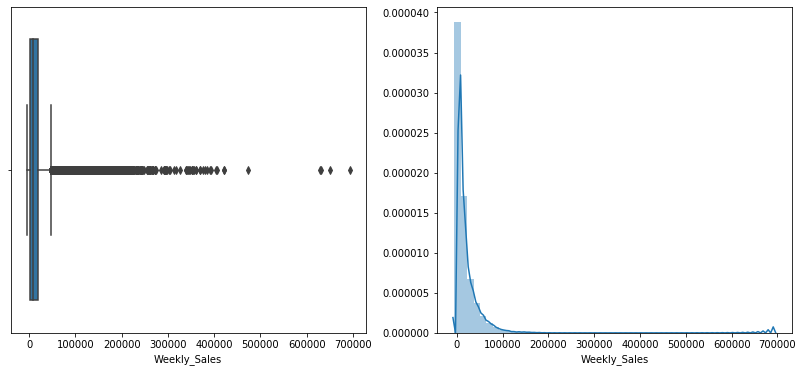

In [28]:
#plot boxplot & distribution plot of the target variable
plt.figure(figsize = (14,6))
plt.subplot(1,2,1)
sns.boxplot(train_df['Weekly_Sales'])
plt.subplot(1,2,2)
sns.distplot(train_df['Weekly_Sales'])

As seen by the box plot & distribution plot, the distribution of the target variable, weekly_sales is positively skewed with a lot of outliers. Let us deep-dive into the outliers to understand better.

In [29]:
#examine the outliers below the lower_bound
train_df[train_df['Weekly_Sales'] < lower_bound]

,Store,Dept,Date,Weekly_Sales,IsHoliday


Looks like we do not have outliers below the lower bound. Next, let us examine the outliers above

In [30]:
#examine the outliers above the upper_bound
train_df[train_df['Weekly_Sales'] > upper_bound]

,Store,Dept,Date,Weekly_Sales,IsHoliday
8,1,1,2010-04-02,57258.43,False
46,1,1,2010-12-24,55931.23,False
63,1,1,2011-04-22,50510.31,False
106,1,1,2012-02-17,54060.10,False
113,1,1,2012-04-06,57592.12,False
...,...,...,...,...,...
421285,45,95,2012-09-28,49380.11,False
421286,45,95,2012-10-05,50241.01,False
421287,45,95,2012-10-12,49334.77,False
421288,45,95,2012-10-19,48434.97,False


Looks like there are a lot of outliers.

#### Feature Engineering on Date feature

Convert Categorical variables into Quantitative variables for better results:

In [31]:
#Convert IsHoliday feature into integer values for easier computations
train_df['IsHolidayInt'] = [int(x) for x in list(train_df.IsHoliday)]

In [35]:
print(train_df.IsHolidayInt)

0         0
1         1
2         0
3         0
4         0
         ..
421565    0
421566    0
421567    0
421568    0
421569    0
Name: IsHolidayInt, Length: 421570, dtype: int64


In [38]:
from datetime import datetime
#strip year from date feature
train_df['year'] = train_df['Date'].dt.year
train_df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,IsHolidayInt,year
0,1,1,2010-02-05,24924.50,False,0,2010
1,1,1,2010-02-12,46039.49,True,1,2010
2,1,1,2010-02-19,41595.55,False,0,2010
3,1,1,2010-02-26,19403.54,False,0,2010
4,1,1,2010-03-05,21827.90,False,0,2010


In [39]:
#strip month from date feature
train_df['month'] = train_df['Date'].dt.month
train_df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,IsHolidayInt,year,month
0,1,1,2010-02-05,24924.50,False,0,2010,2
1,1,1,2010-02-12,46039.49,True,1,2010,2
2,1,1,2010-02-19,41595.55,False,0,2010,2
3,1,1,2010-02-26,19403.54,False,0,2010,2
4,1,1,2010-03-05,21827.90,False,0,2010,3


In [44]:
#strip year from date feature
train_df['week_day'] = train_df['Date'].dt.weekday
train_df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,IsHolidayInt,year,month,day,week_day,weekday
0,1,1,2010-02-05,24924.50,False,0,2010,2,5,4,4
1,1,1,2010-02-12,46039.49,True,1,2010,2,12,4,4
2,1,1,2010-02-19,41595.55,False,0,2010,2,19,4,4
3,1,1,2010-02-26,19403.54,False,0,2010,2,26,4,4
4,1,1,2010-03-05,21827.90,False,0,2010,3,5,4,4


In [45]:
#drop Date column as we already have extracted informations from it - 
train_df = train_df.drop('Date', axis=1)

## Visualize features & trends with Weekly_Sales

Amount of Departments across all stores

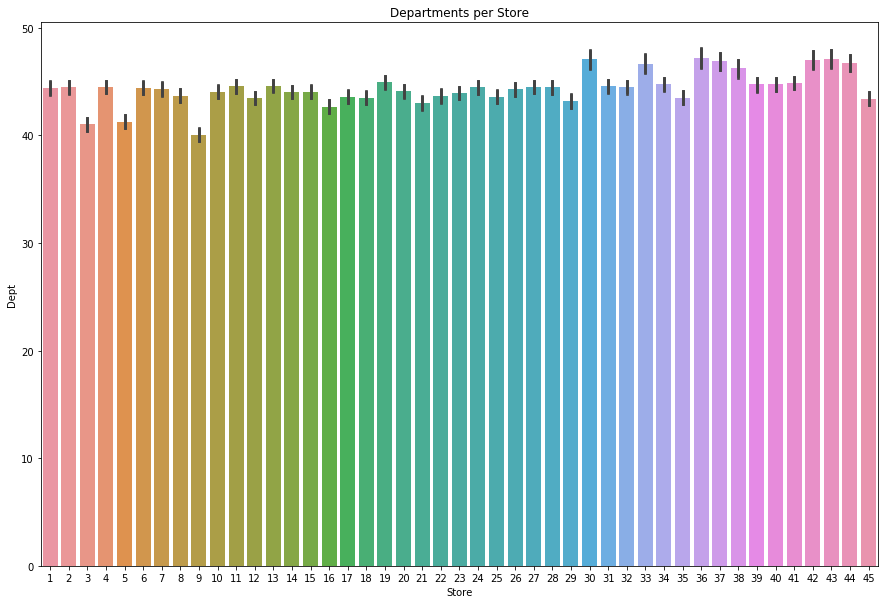

In [47]:
#plot to visualize the variance in departments across all stores
plt.figure(figsize=(15,10))
ax= sns.barplot(train_df.Store, train_df.Dept, alpha=0.8)
sns.barplot(train_df.Store, train_df.Dept)
plt.title("Departments per Store")
plt.show()

All the stores seem to have similar amount of departments with slight differences in few. With more information on department types, we could have also visualized the types of departments that are most common across all stores

Now let us get a high-level overview of weekly sales performance of all stores.

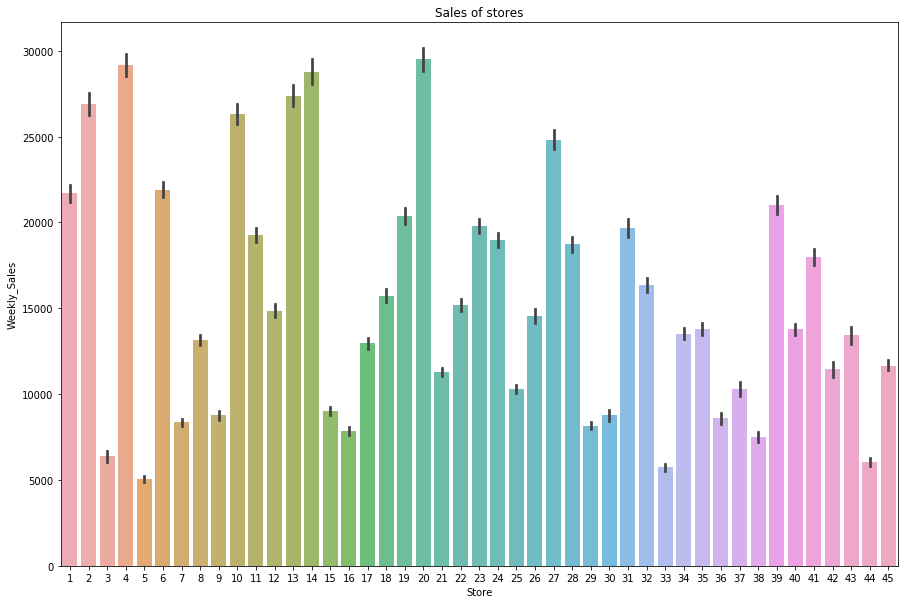

In [49]:
# plot bar chart to see weekly_sales performance of each store
plt.figure(figsize=(15,10))
ax= sns.barplot(train_df.Store, train_df.Weekly_Sales, alpha=0.8)
plt.title("Sales of stores")
plt.show()

By the above plot, we can see that stores - 4, 14 & 20 are the high performing ones. While, 5th & 44th are amongst the lowest. There could be a variety of factors effecting these. With more demographical data of these stores, we would be able to visualize better.

Now let us zoom in to visualize the monthly trends of sales for each year.

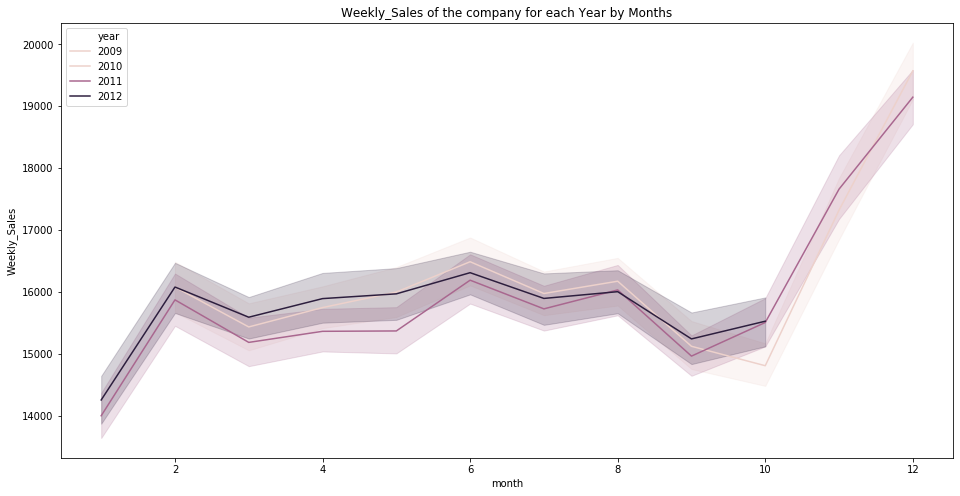

In [50]:
#plot line plot to visualize the trends of sales of the retail company for each year by months
plt.figure(figsize=(16,8))
plt.title('Weekly_Sales of the company for each Year by Months')
plt.xlabel('Month')
plt.ylabel('Sales')
sns.lineplot(train_df.month, train_df.Weekly_Sales, hue = train_df.year)

There is an obvious seasonality, i.e. peak sales at the end of the year


Let us picture how the sales vary year-wise during Thanksgiving time.
i.e October

Text(0.5, 1.0, 'Weekly Sales of stores')

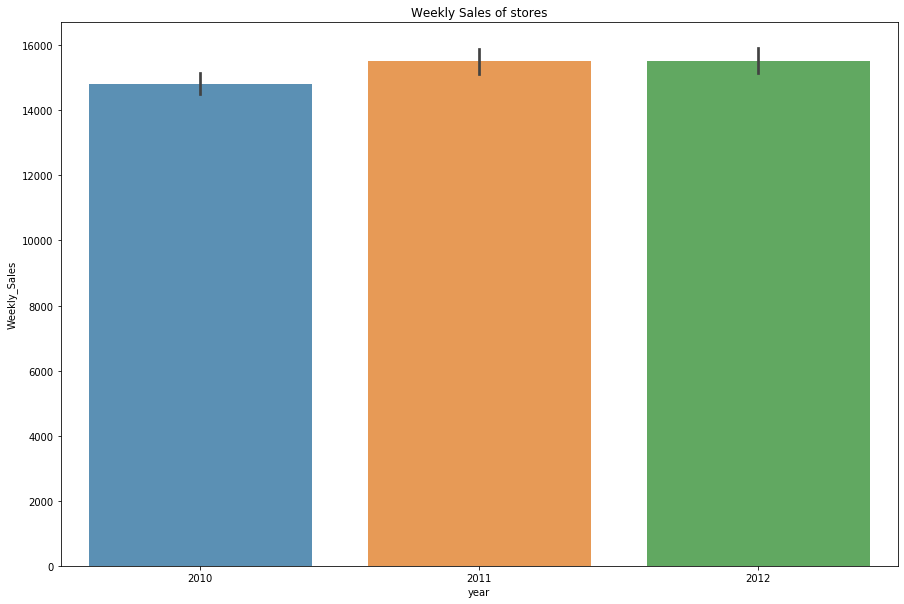

In [51]:
#plot bar chart to visualize sales year-wise for the month of October
october=train_df[train_df['month'] == 10]
plt.figure(figsize=(15,10))
ax= sns.barplot(october.year, october.Weekly_Sales, alpha=0.8)
plt.title("Weekly Sales of stores")

Now let us deep dive into performance of stores for each year during Thanksgiving time.



In [52]:
#function to plot bar chart of performance of stores for each year during Thanksgiving time-
def thanksgiving_year(year):
    plt.figure(figsize=(15,10))
    plt.title(year)
    mnth = train_df['month'] == 10
    yr = train_df['year'] == year
    october=train_df[mnth & yr]
    ax= sns.barplot(october.Store, october.Weekly_Sales, alpha=0.8)

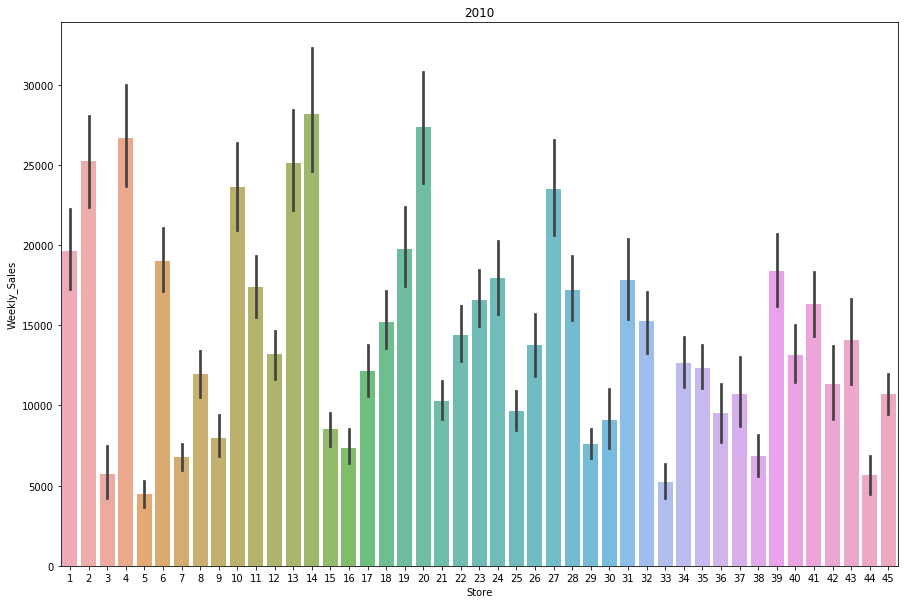

In [53]:
#plot bar chart of performance of stores for 2010 during Thanksgiving time
thanksgiving_year(2010)

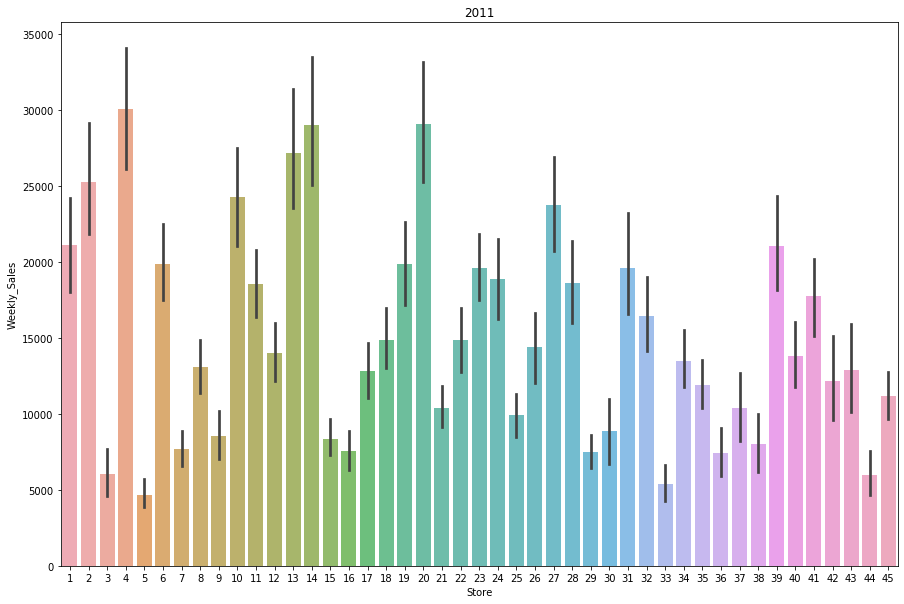

In [54]:
#plot bar chart of performance of stores for 2011 during Thanksgiving time
thanksgiving_year(2011)

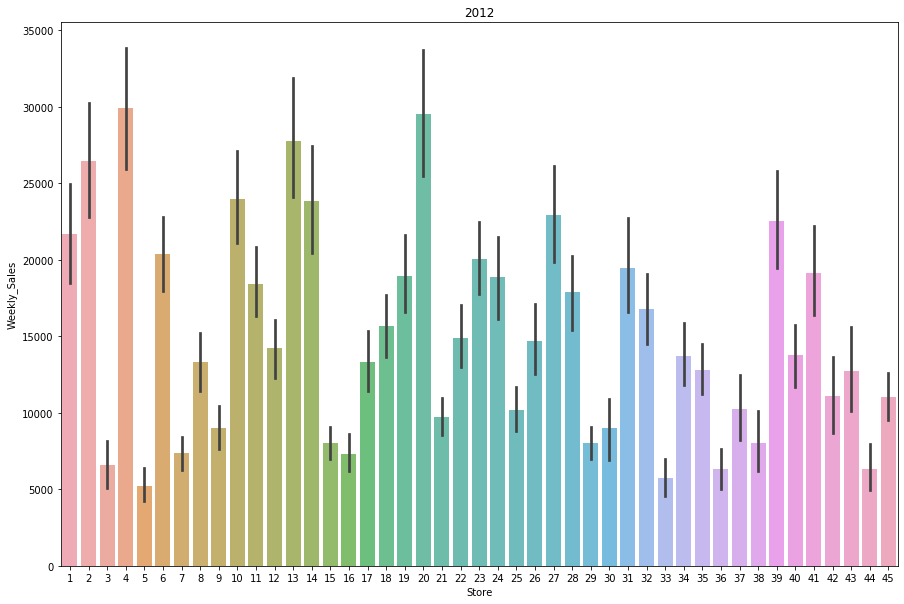

In [55]:
#plot bar chart of performance of stores for 2012 during Thanksgiving time
thanksgiving_year(2012)

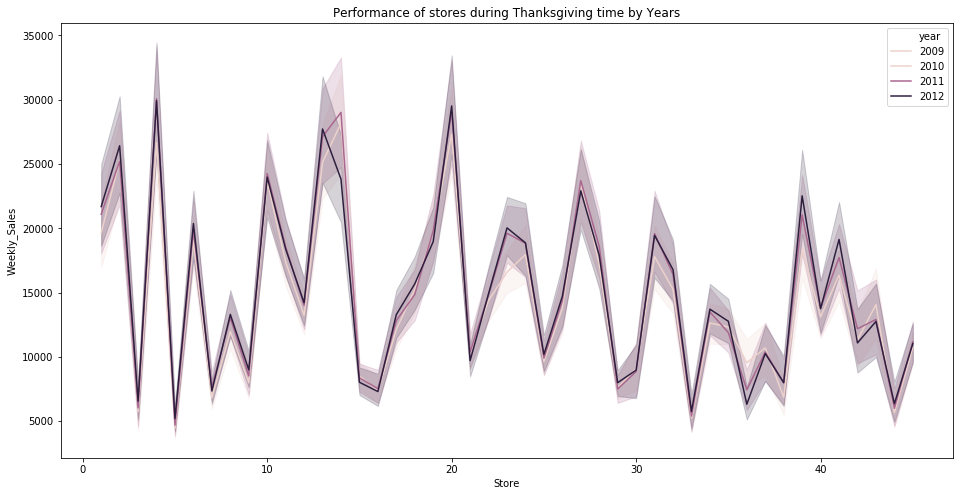

In [56]:
#plot line plot to visualize the trends of store performances for each year during Thanksgiving time
plt.figure(figsize=(16,8))
plt.title('Performance of stores during Thanksgiving time by Years')
plt.xlabel('Store')
plt.ylabel('Sales')
mnth = train_df['month'] == 10
october=train_df[mnth]
sns.lineplot(october.Store, october.Weekly_Sales, hue = october.year)

This looks like a seasonal trend of sales store-wide across all years during Thanksgiving time in our data.

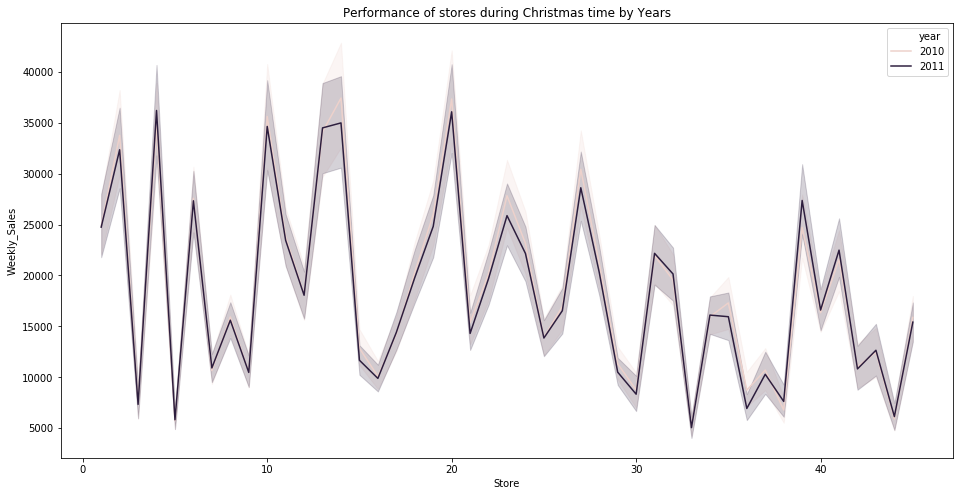

In [57]:
#plot line plot to visualize the trends of store performances for each year during Christmas time
plt.figure(figsize=(16,8))
plt.title('Performance of stores during Christmas time by Years')
plt.xlabel('Store')
plt.ylabel('Sales')
mnth_12 = train_df['month'] == 12
december=train_df[mnth_12]
sns.lineplot(december.Store, december.Weekly_Sales, hue = december.year)

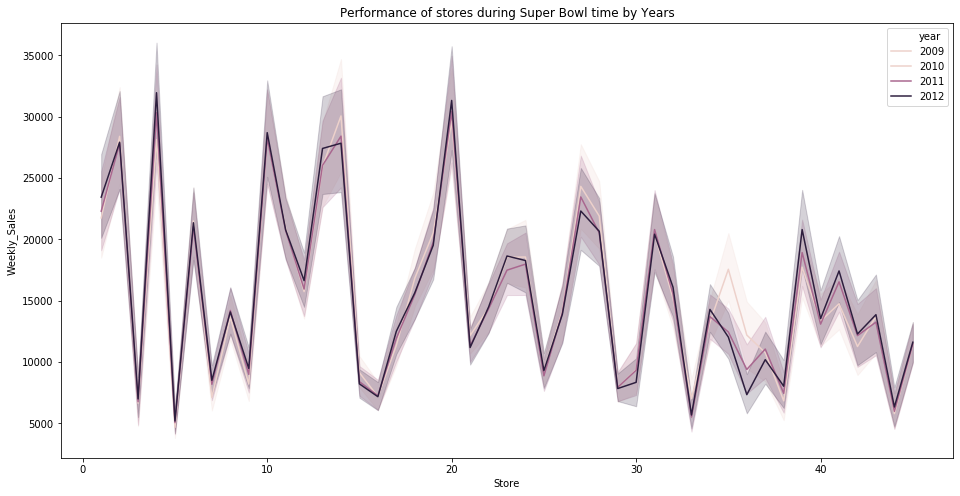

In [58]:
##plot line plot to visualize the trends of store performances for each year during Super Bowl time
plt.figure(figsize=(16,8))
plt.title('Performance of stores during Super Bowl time by Years')
plt.xlabel('Store')
plt.ylabel('Sales')
mnth_02 = train_df['month'] == 2
feb=train_df[mnth_02]
sns.lineplot(feb.Store, feb.Weekly_Sales, hue = feb.year)

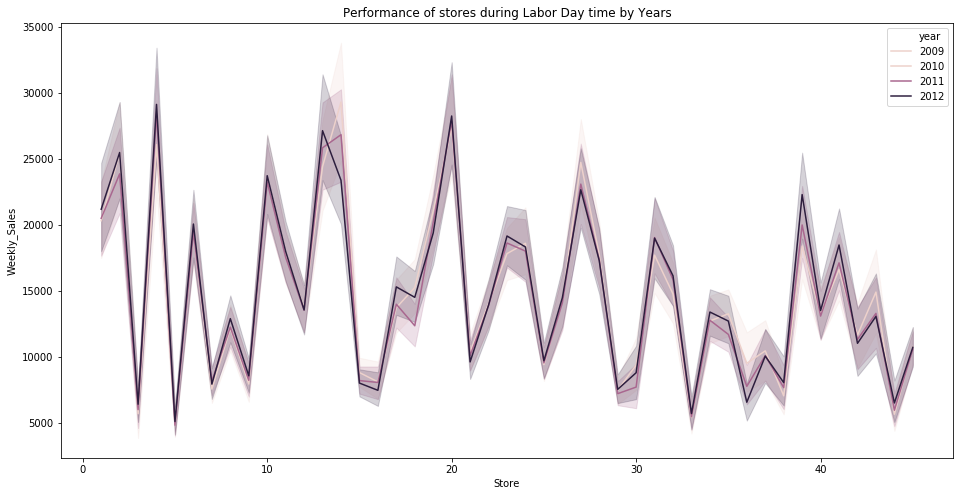

In [59]:
##plot line plot to visualize the trends of store performances for each year during Labor Day time
plt.figure(figsize=(16,8))
plt.title('Performance of stores during Labor Day time by Years')
plt.xlabel('Store')
plt.ylabel('Sales')
mnth_09 = train_df['month'] == 9
sept=train_df[mnth_09]
sns.lineplot(sept.Store, sept.Weekly_Sales, hue = sept.year)

This looks like a seasonal trend of sales store-wide across all years during Labor Day time in our data.

Holiday season, especially Christmas time definitely affect the sales across all stores. However, certain stores have relatively quite low performance. We can possibly understand the reasons for those given more demographical data of all the stores.

Now let us visualize the performance of departments with respect to different stores sorted by date.

(143, 10)


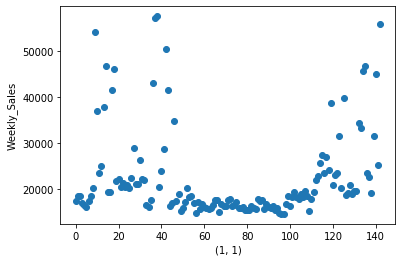

(143, 10)


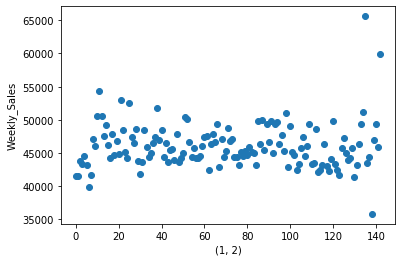

(143, 10)


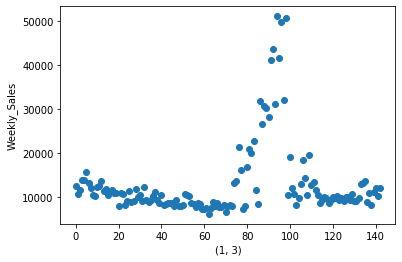

(143, 10)


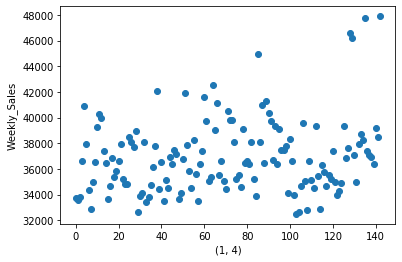

(143, 10)


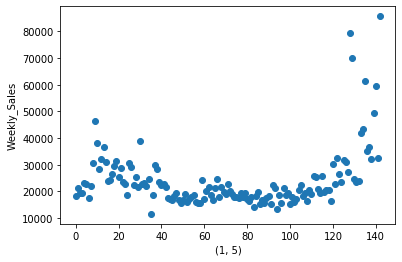

(143, 10)


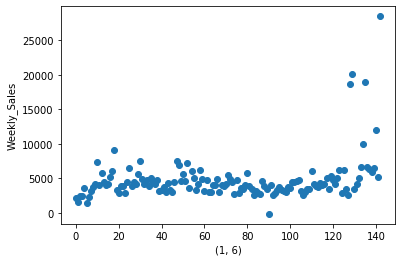

(143, 10)


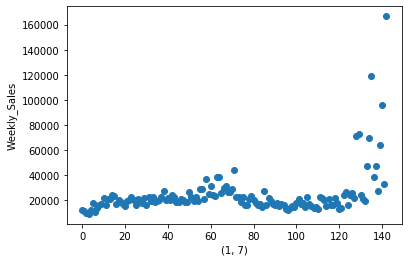

(143, 10)


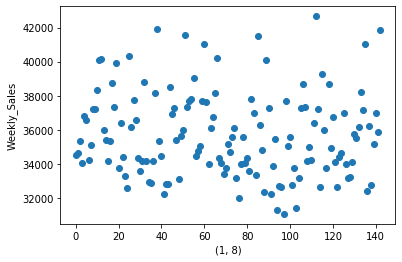

(143, 10)


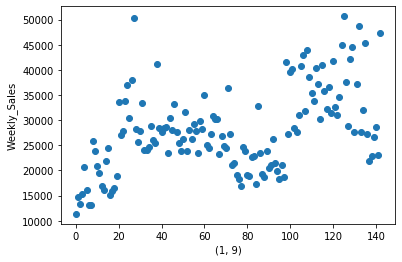

(143, 10)


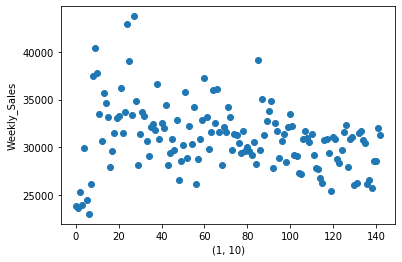

(143, 10)


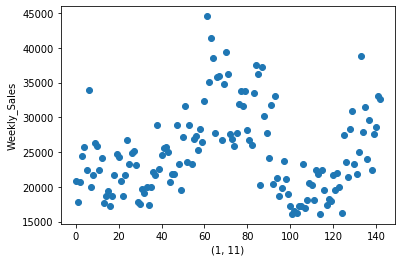

(143, 10)


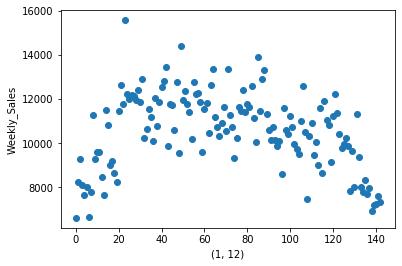

In [61]:
#plot performance of departments for respective stores sorted by date-
count = 0
for store, dept in train_df.groupby(["Store", "Dept"]):
    plt.ylabel('Weekly_Sales')
    plt.xlabel(store)
    print(dept.shape)
    dept = dept.sort_values(by=['month'])
    plt.scatter(range(len(dept)), dept["Weekly_Sales"])
    plt.show()
    if count > 10:
        break
    count += 1

Dept-vs-Weekly_Sales plot shows noticable relations, but no obvious linearality has been observed in any plot.

In the plots of the weekly sales of each store and department, we see different trends in each plot, indicating that the features may affect the weekly sales of each department in each store differently.

Let us visualize the IsHoliday feature.

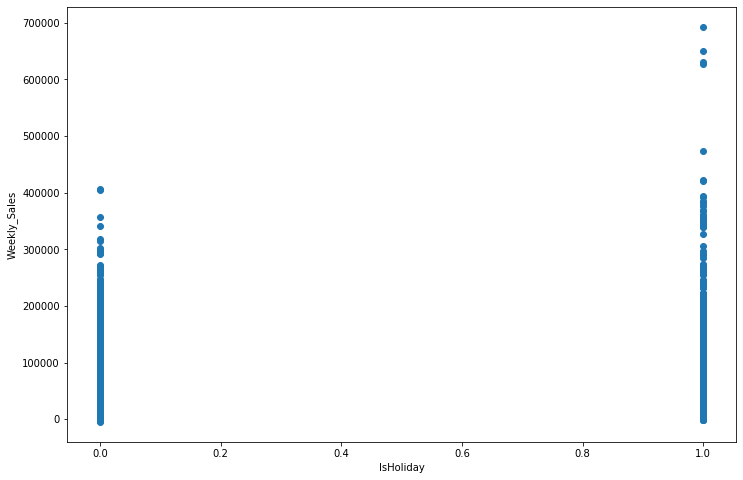

In [63]:
scatter_data(train_df,'IsHoliday')

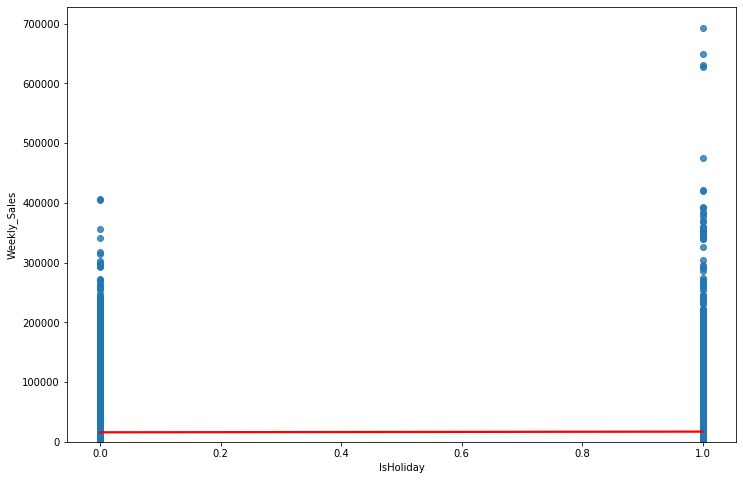

In [64]:
#Fit a regression line to IsHoliday feature to visualize them as a predictor of Weekly_Sales - 
reg_data(train_df,'IsHoliday')

### Correlation between all the features

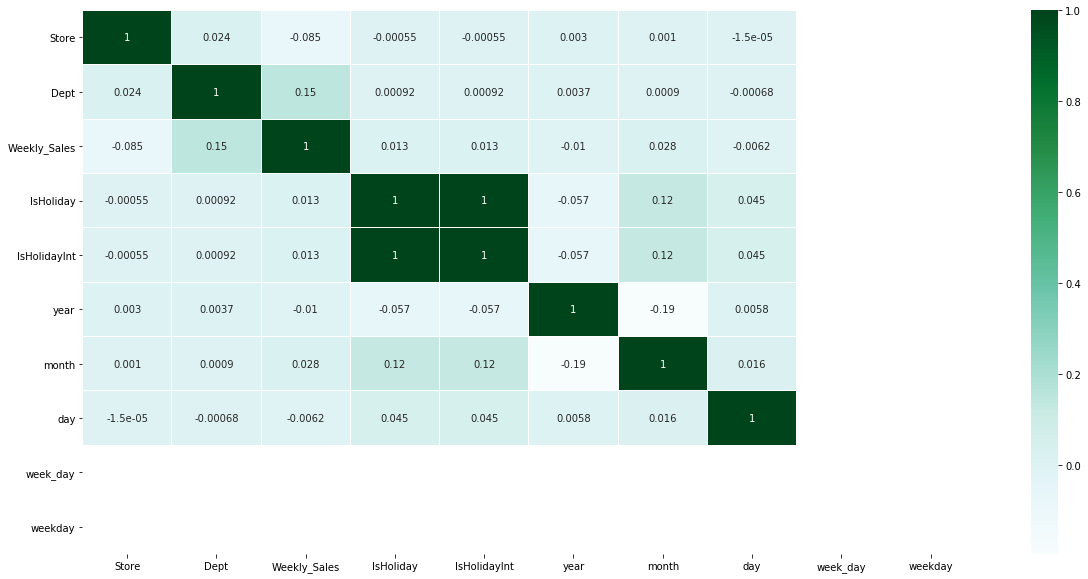

In [65]:
# Plot heatmap of all data with correlation coefficients vis
train_df_corr = train_df.corr()
plt.subplots(figsize=(20,10))
sns.heatmap(train_df_corr, cmap = 'BuGn', linewidth =.005, annot = True)


Pearson correlation coefficient of -1 or +1 also suggest that the relationship between two variables is strong, while two features that are not monotonically related can have a very small correlation coefficient (~0). From the matrix above, we can see that the correlation coefficients between Weekly_Sales and other features are considerbly small, showing that they do not have strong monotonic relations.

# 4. Modelling & evaluation

To create a basic training model, two variables will be assigned for the model to use. Twenty percent of the training data will be split into testing data that we can use to test the model with data for which the Weekly_Sales are already known.

In [67]:
#Split the data and assign 'Weekly_Sales' to 'sales_df' and the rest of the features to 'feat_df'. 
feat_df = train_df[train_df.loc[ :, train_df.columns != 'Weekly_Sales'].columns]
sales_df = train_df['Weekly_Sales']
feat_train, feat_test, sales_train, sales_test = train_test_split(feat_df, sales_df, test_size = 0.2, random_state = 1)

In [68]:
#View inputs and outputs of training model
print('Inputs- \n', feat_train.head())
print('Outputs- \n', sales_train.head())

Inputs- 
         Store  Dept  IsHoliday  IsHolidayInt  year  month  day  week_day  \
368380     39    72       True             1  2010     12   31         4   
160775     17    25      False             0  2011      7    1         4   
31543       4    16      False             0  2010      7   16         4   
30033       4     4      False             0  2011      9   30         4   
114759     12    60      False             0  2010      4    2         4   

        weekday  
368380        4  
160775        4  
31543         4  
30033         4  
114759        4  
Outputs- 
 368380    55278.88
160775     7229.18
31543     30849.37
30033     53790.29
114759      484.00
Name: Weekly_Sales, dtype: float64


We will use linear regression here as Weekly_Sales is a continious variable. With all the data, we see that this is a case of Supervised Regression learning. We will establish the baseline model by appling Linear Regression to feat_train, sales_train.

In [69]:
#Create Linear Regression Object and fit the model
lm = LinearRegression()
lm.fit(feat_train,sales_train)
lm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Next, we will view the coefficients of our model -



In [70]:
#View coeff of Linear Regression object
print(lm.intercept_)
print(lm.coef_)

190110.0299185836
[-156.99856497  111.48509331  351.46451656  351.46451656  -87.79725775
  189.59679604  -19.466336      0.            0.        ]


Now that the baseline model is created, it can predict the salaries. The variable yhat is used to store the predictions using the training data.

In [71]:
#predict Weekly_Sales using training data
yhat = lm.predict(feat_train)

#View first five predictions -
print('First five predictions:' , yhat[0:5])

First five predictions: [17916.15868717 14975.60753981 15809.02526243 14490.07177311
 19162.11916408]


Mean squared error (MSE) will be evaluated now along with accuracy and r-squared to evaluate the baseline model's performance and to determine if the subsequent models improve over the established baseline model.

In [72]:
#print MSE - 
print('Mean Squared Error of our prediction model', mean_squared_error(sales_train, yhat))

Mean Squared Error of our prediction model 499612845.7107838


In [73]:
#print MAE - 

print('Mean Absolute Error of our prediction model', mean_absolute_error(sales_train, yhat))

Mean Absolute Error of our prediction model 15098.242242613924


In [74]:
# accuracy of the baseline model using 5-cross validation method -
score = cross_val_score(lm, feat_train, sales_train, cv = 5)
print('5-Cross Validation accuracy', (np.mean(score)), (np.std(score)))

5-Cross Validation accuracy 0.030449955724047406 0.0013592218803569313


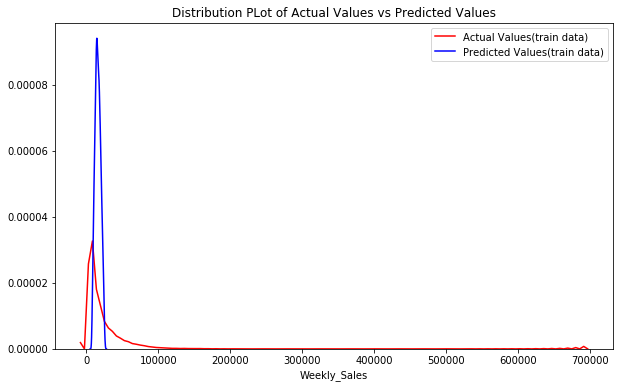

In [75]:
#distribution plot 
Title = 'Distribution PLot of Actual Values vs Predicted Values'
dis_data(sales_train, yhat, 'Actual Values(train data)', 'Predicted Values(train data)', Title)

Next, we do the same for the 20% test data to see if the outcome is similar.



In [76]:
#store test set predictions in yhat_test 
yhat_test = lm.predict(feat_test)

#view first five predictions - 
print('First five predictions(test data)', yhat_test[0:5])

First five predictions(test data) [14718.21028934 17883.01875007 15301.03881711 21468.4080009
 14587.85756566]


In [77]:
#MSE of test data - 
print('Mean Squared Error of test data ', mean_squared_error(sales_test, yhat_test))

Mean Squared Error of test data  501237248.38941765


In [78]:
#MAE of test data - 
print('Mean Absolute Error of test data ', mean_absolute_error(sales_test, yhat_test))

Mean Absolute Error of test data  15139.550551376493


MAE of test data is slightly more than the MAE of training data

In [79]:
#accuracy of test data using 5-cross validation method - 
score = cross_val_score(lm, feat_test, sales_test, cv = 5)
print('5-cross validation accuracy(test data)', (np.mean(score)), (np.std(score)))

5-cross validation accuracy(test data) 0.031694803029623374 0.0015742766535291443


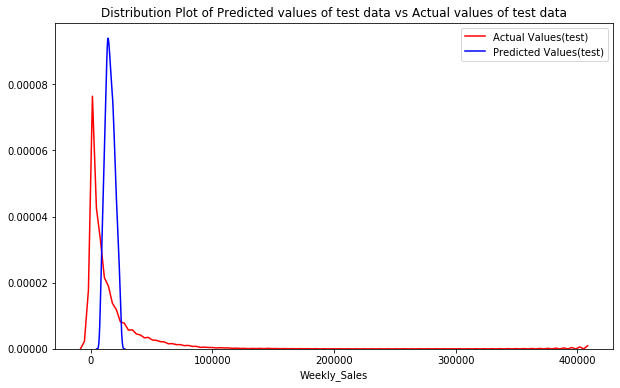

In [80]:
#Distribution plot 
Title = 'Distribution Plot of Predicted values of test data vs Actual values of test data'
dis_data(sales_test, yhat_test, 'Actual Values(test)', 'Predicted Values(test)', title = Title)

#### Three models that may improve results over the baseline model are -

- Apply Polynomial Transformation
- Use Ridge Regression
- Use Random Forest

The shape and features of the training data and testing data will be checked before applying models on them.



In [81]:
#shape and features -

print('Number of training samples-', feat_train.shape, '\n with the features-', feat_train.columns) 
print('Number of testing samples-', feat_test.shape, '\n with the features-', feat_test.columns)
print('Number of training weekly_sales-', sales_train.shape)
print('Number of testing weekly_sales-', sales_test.shape)

Number of training samples- (337256, 9) 
 with the features- Index(['Store', 'Dept', 'IsHoliday', 'IsHolidayInt', 'year', 'month', 'day',
       'week_day', 'weekday'],
      dtype='object')
Number of testing samples- (84314, 9) 
 with the features- Index(['Store', 'Dept', 'IsHoliday', 'IsHolidayInt', 'year', 'month', 'day',
       'week_day', 'weekday'],
      dtype='object')
Number of training weekly_sales- (337256,)
Number of testing weekly_sales- (84314,)


We will first apply Polynomial Features to already built Linear regression model and see if MAE reduces.



In [82]:
#Fit and transform the variables with 2nd order polynomial
pr = PolynomialFeatures(2)
feat_train_pr = pr.fit_transform(feat_train)
feat_test_pr = pr.fit_transform(feat_test)
pr

PolynomialFeatures(degree=2, include_bias=True, interaction_only=False,
                   order='C')

In [83]:
#Create a new model using Polynomial Transformation 
poly = LinearRegression()
poly.fit(feat_train_pr, sales_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [84]:
#make predictions and view first five predictions on train data - 
yhat_pr = poly.predict(feat_train_pr)
print('First five predictions(train data)-', yhat_pr[0:5])

First five predictions(train data)- [13368.51575923 11807.06125444 17875.35721183 26025.43110693
 12021.33329785]


In [85]:
#Compare first five predicted values vs actual values - 
print('Predicted Values(train)-', yhat_pr[0:5])
print('Actual Values(train)-', sales_train[0:5].values)

Predicted Values(train)- [13368.51575923 11807.06125444 17875.35721183 26025.43110693
 12021.33329785]
Actual Values(train)- [55278.88  7229.18 30849.37 53790.29   484.  ]


In [86]:
#make predictions and view first five predictions on test data - 
yhat_prtest = poly.predict(feat_test_pr)
print('First five predictions(test data)-', yhat_prtest[0:5])

First five predictions(test data)- [ 5621.2895689  14784.52574641  8128.81688935 21862.19944084
  5851.72154278]


In [87]:
#Compare predicted values of test data and actual values of test data - 
print('Predicted values(test)-', yhat_prtest[0:5])
print('Actual values(test)-', sales_test[0:5].values)

Predicted values(test)- [ 5621.2895689  14784.52574641  8128.81688935 21862.19944084
  5851.72154278]
Actual values(test)- [  202.76 16482.   48167.29 21581.64  1315.  ]


In [88]:

#print R-squared values of training and testing data - 
print('R-squared of training data-', poly.score(feat_train_pr, sales_train))
print('R-squared of testing data-', poly.score(feat_test_pr, sales_test))

R-squared of training data- 0.12068700575562787
R-squared of testing data- 0.12375719891000847


In [89]:
#MAE of training and testing data - 
print('MAE of training data-', mean_absolute_error(sales_train, yhat_pr))
print('MAE of testing data-', mean_absolute_error(sales_test, yhat_prtest))

MAE of training data- 13528.38299945083
MAE of testing data- 13550.550393216328


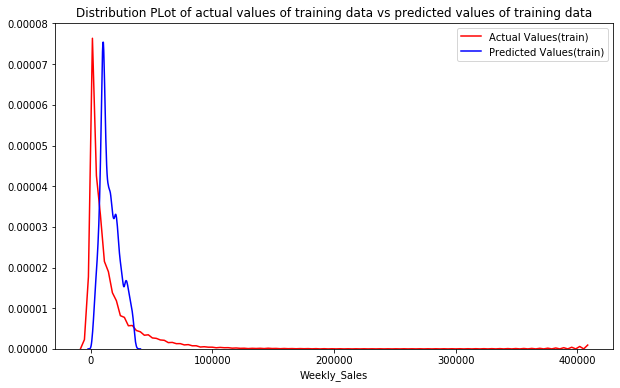

In [90]:
#View distribution plot of actual vs fitted of training data - 
dis_data(sales_test, yhat_pr, 'Actual Values(train)', 'Predicted Values(train)', title = 'Distribution PLot of actual values of training data vs predicted values of training data')

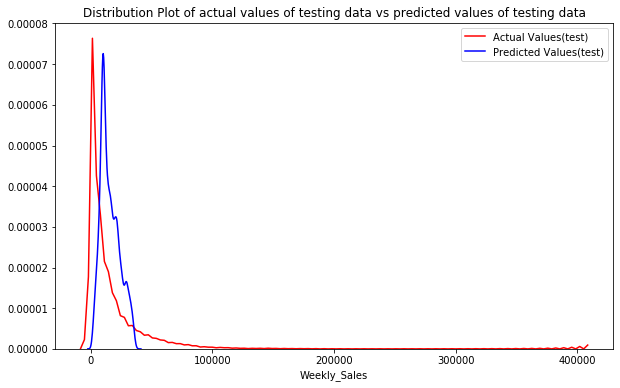

In [92]:
#view distribution plot of actual vs fitted of testing data - 
dis_data(sales_test, yhat_prtest, 'Actual Values(test)', 'Predicted Values(test)', title = 'Distribution Plot of actual values of testing data vs predicted values of testing data')

Now we will check if applying Ridge regression reduces MAE



In [93]:
#create a ridge regression object and fit it to training data 
RidgeModel = Ridge(alpha = 1.0)
RidgeModel.fit(feat_train_pr, sales_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [94]:
#predict values of training data and testing data
yhat_Ridge_train = RidgeModel.predict(feat_train_pr)
yhat_Ridge_test = RidgeModel.predict(feat_test_pr)

In [95]:
#compare actual and predicted values of training data 
print('Predicted Values(train)-', yhat_Ridge_train[0:5])
print('Actual Values(train)-', sales_train[0:5].values)

Predicted Values(train)- [13371.68187407 11847.18268224 17853.18166026 26067.7190874
 11996.28049427]
Actual Values(train)- [55278.88  7229.18 30849.37 53790.29   484.  ]


In [96]:
#compare actual and predicted values of testing data 
print('Predicted Values(test)-', yhat_Ridge_test[0:5])
print('Actual Values(test)-', sales_test[0:5].values)

Predicted Values(test)- [ 5605.8334166  14818.6656433   8098.3057452  21895.59467514
  5890.29690132]
Actual Values(test)- [  202.76 16482.   48167.29 21581.64  1315.  ]


In [97]:
#R-squared of training and testing data - 
print('R-squared values(train)-', RidgeModel.score(feat_train_pr, sales_train))
print('R-squared values(test)-', RidgeModel.score(feat_test_pr, sales_test))

R-squared values(train)- 0.1206851555275884
R-squared values(test)- 0.12373258919753238


In [98]:
#MAE of training and testing data - 
print('MAE of training data-', mean_absolute_error(sales_train, yhat_Ridge_train))
print('MAE of testing data-', mean_absolute_error(sales_test, yhat_Ridge_test))

MAE of training data- 13528.455457841515
MAE of testing data- 13550.801999611685


We see no improvement using alpha = 1.0

Let us now use Grid Search to ensure right hyperparameters are used -

In [99]:
#define the hyperparameter - 
parameters1 = [{'alpha': [0.001,0.1,1, 10, 100, 1000, 10000, 100000, 100000]}]
parameters1

[{'alpha': [0.001, 0.1, 1, 10, 100, 1000, 10000, 100000, 100000]}]

In [100]:
#Create a new Ridge Regression object - 
RM = Ridge()

In [101]:
#create a gridsearch object and pass RM, parameters1 to it. 
Grid = GridSearchCV(RM, parameters1, cv = 5)

In [102]:
#fit the grid search model to the training data - 
Grid.fit(feat_train, sales_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': [0.001, 0.1, 1, 10, 100, 1000, 10000, 100000,
                                    100000]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [103]:
#assign best estimator - 
bestRM = Grid.best_estimator_
bestRM

Ridge(alpha=1000, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [104]:
#Test model using test data - 
bestRM.score(feat_test, sales_test)

0.03166618506296637


We do not see any significant improvement here. Perhaps the performance could improve if we had more data.

Next let us try using Random Forest and Fit a Randorm Forest with random_state = 1 for consistency

In [105]:
#create a random forest object - 
RF = RandomForestRegressor(n_estimators = 150, n_jobs = 2, max_features = 7)
RF

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=7, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=150, n_jobs=2, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [106]:
#fit a Random Forest model on training data - 
RF.fit(feat_train, sales_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=7, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=150, n_jobs=2, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [107]:
#make predictions on testing data and print the first five - 
yhat_RF_test = RF.predict(feat_test)
print('First five predictions-', yhat_RF_test[0:5])

First five predictions- [  288.49546667 13694.48086667 48724.19106667 25942.56466667
  1449.46886667]


In [108]:
#R-squared and MAE of test data - 
print('R-squared of test data-', RF.score(feat_test, sales_test))
print('MAE of test data-', mean_absolute_error(sales_test, yhat_RF_test))

R-squared of test data- 0.9703812954529696
MAE of test data- 1456.2157633923982


In [109]:
score = cross_val_score(RF, feat_test, sales_test, cv = 5, scoring = 'r2')
print('5-cross validation accuracy(test data)', (np.mean(score)), (np.std(score)))

5-cross validation accuracy(test data) 0.9438099886955982 0.006916047013535573


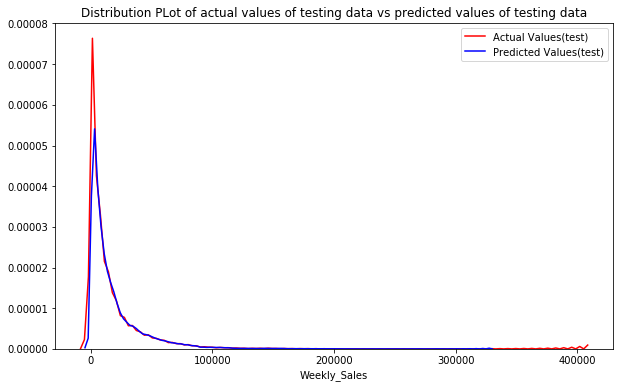

In [110]:
#view distribution plot of actual vs fitted of testing data - 
dis_data(sales_test, yhat_RF_test, 'Actual Values(test)', 'Predicted Values(test)', title = 'Distribution PLot of actual values of testing data vs predicted values of testing data')


We can see that the Random forest regressor performed best (having the lowest mean absolute error of 1783.60318 and high R-squared of 95%) compared to other models. Therefore, we pick this one to be our base model, and we will fine-tune the model in the next section.

# 5.Automate and Deploy the model
 

#### Automate pipeline
To deploy the selected model, a data pipeline will be created to automate the needed transformations once data is given as an input to the model.

In [112]:
#create pipeline for random forest regression 
input = [('scale', StandardScaler()), ('model', RandomForestRegressor(n_estimators = 150, n_jobs = 2, max_features = 7))]
pipe = Pipeline(input)
pipe

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mse', max_depth=None,
                                       max_features=7, max_leaf_nodes=None,
                                       max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=150, n_jobs=2,
                                       oob_score=False, random_state=None,
                                       verbose=0, warm_start=False))],
         verbose=False)

In [113]:
#fit the pipeline to the entire training data - 
RFmodel = pipe.fit(feat_df, sales_df)

The pipeline will Normalize and produce predictions ..



In [114]:
#make predictions on the test data and print first five - 
ypipe = pipe.predict(feat_df)
ypipe[0:5]

array([26615.41966667, 45449.0852    , 39918.5508    , 21557.22506667,
       22243.54226667])

Now the model will be saved so it can be used whenever needed.



In [115]:
filename = 'Sales_forecasting_model.csv'
joblib.dump(RFmodel, filename)

['Sales_forecasting_model.csv']

We can now load the model to a variable and add new data to it -



In [117]:
#load model 
loaded_m = joblib.load(filename)

In [118]:
#see results of test data with known Weekly_Sales - 
result = loaded_m.score(feat_test, sales_test)
print(result)

0.996363196678075


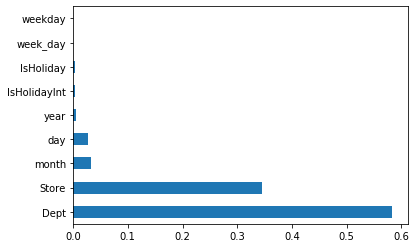

In [119]:
#PLot feature importances -
feat_importances = pd.Series(RF.feature_importances_, index=feat_df.columns)
feat_importances.nlargest(10).plot(kind='barh')


# Summary
Using a Random Forest Regressor Model gave the most accurate results. The result was a mean absolute error of 1783.6 with the accuracy of 95.7%.

This model can be used as a guide when determining Weekly_Sales since it results in a resonable predictions when given information on years of store, department, dates & whether it is a holdiay or not.